# NOTEBOOK 02: FEATURE ENGINEERING
## Credit Risk Early Warning System

**OBJECTIVES:**
1. Create ratio features from application_train (debt-to-income, payment burden)
2. Aggregate features from bureau.csv (external loan history)
3. Aggregate features from previous_application.csv (Home Credit history)
4. Combine all features into a single feature matrix
5. Save processed data for model training

**KEY PRINCIPLE:** 
Feature engineering is where domain knowledge meets data science. 
We transform raw data into signals that help predict default risk.

# 1. Setup and Data Loading

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import gc  # Garbage collector for memory management

# Configuration
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# Define paths - Use absolute path to ensure consistency
# __vsc_ipynb_file__ is provided by VS Code, fallback to manual path if not available
try:
    NOTEBOOK_DIR = Path(__vsc_ipynb_file__).parent
except NameError:
    NOTEBOOK_DIR = Path(r"c:\Users\carlo\Documents\4.DS\credit-risk-early-warning-system\notebooks")

PROJECT_ROOT = NOTEBOOK_DIR.parent
DATA_RAW = PROJECT_ROOT / 'data' / 'raw'
DATA_PROCESSED = PROJECT_ROOT / 'data' / 'processed'

# Create processed folder if it doesn't exist
DATA_PROCESSED.mkdir(parents=True, exist_ok=True)

print(f"Project root: {PROJECT_ROOT}")
print(f"Raw data path: {DATA_RAW}")
print(f"Processed data path: {DATA_PROCESSED}")

Project root: c:\Users\carlo\Documents\4.DS\credit-risk-early-warning-system
Raw data path: c:\Users\carlo\Documents\4.DS\credit-risk-early-warning-system\data\raw
Processed data path: c:\Users\carlo\Documents\4.DS\credit-risk-early-warning-system\data\processed


In [2]:
# Load the main training dataset
print("Loading application_train.csv...")
df = pd.read_csv(DATA_RAW / 'application_train.csv')
print(f"Application train loaded: {df.shape[0]:,} rows × {df.shape[1]} columns")

# Load bureau data (loans from other institutions)
print("\nLoading bureau.csv...")
bureau = pd.read_csv(DATA_RAW / 'bureau.csv')
print(f"Bureau loaded: {bureau.shape[0]:,} rows × {bureau.shape[1]} columns")

# Load previous applications at Home Credit
print("\nLoading previous_application.csv...")
prev_app = pd.read_csv(DATA_RAW / 'previous_application.csv')
print(f"Previous applications loaded: {prev_app.shape[0]:,} rows × {prev_app.shape[1]} columns")

print("\n✅ All datasets loaded successfully!")

Loading application_train.csv...
Application train loaded: 307,511 rows × 122 columns

Loading bureau.csv...
Bureau loaded: 1,716,428 rows × 17 columns

Loading previous_application.csv...
Previous applications loaded: 1,670,214 rows × 37 columns

✅ All datasets loaded successfully!


In [7]:
# Method 4: As a DataFrame for easier viewing
with pd.option_context('display.max_rows', None):
    print(pd.DataFrame({'Column Name': df.columns, 'Data Type': df.dtypes.values}))

                      Column Name Data Type
0                      SK_ID_CURR     int64
1                          TARGET     int64
2              NAME_CONTRACT_TYPE    object
3                     CODE_GENDER    object
4                    FLAG_OWN_CAR    object
5                 FLAG_OWN_REALTY    object
6                    CNT_CHILDREN     int64
7                AMT_INCOME_TOTAL   float64
8                      AMT_CREDIT   float64
9                     AMT_ANNUITY   float64
10                AMT_GOODS_PRICE   float64
11                NAME_TYPE_SUITE    object
12               NAME_INCOME_TYPE    object
13            NAME_EDUCATION_TYPE    object
14             NAME_FAMILY_STATUS    object
15              NAME_HOUSING_TYPE    object
16     REGION_POPULATION_RELATIVE   float64
17                     DAYS_BIRTH     int64
18                  DAYS_EMPLOYED     int64
19              DAYS_REGISTRATION   float64
20                DAYS_ID_PUBLISH     int64
21                    OWN_CAR_AG

In [9]:
# =============================================================================
# EXPLORE COLUMNS AND DATA DICTIONARY
# =============================================================================

import textwrap

# Set pandas to show everything
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Load data dictionary
data_dict = pd.read_csv(DATA_RAW / 'HomeCredit_columns_description.csv', encoding='cp1252')

# Show all columns with their types and descriptions
print("=" * 100)
print("APPLICATION_TRAIN COLUMNS REFERENCE")
print("=" * 100)

app_dict = data_dict[data_dict['Table'] == 'application_{train|test}.csv']

for i, col in enumerate(df.columns):
    dtype = str(df[col].dtype)
    null_pct = df[col].isnull().mean() * 100
    match = app_dict[app_dict['Row'] == col]
    desc = match.iloc[0]['Description'] if len(match) > 0 else "N/A"
    
    # Wrap description at 80 characters, with indentation for continuation lines
    wrapped_desc = textwrap.fill(desc, width=80, subsequent_indent='                  ')
    
    print(f"\n{i+1:3}. {col:35} | {dtype:10} | {null_pct:5.1f}% null")
    print(f"     Description: {wrapped_desc}")

print(f"\n{'=' * 100}")
print(f"Total columns: {len(df.columns)}")

APPLICATION_TRAIN COLUMNS REFERENCE

  1. SK_ID_CURR                          | int64      |   0.0% null
     Description: ID of loan in our sample

  2. TARGET                              | int64      |   0.0% null
     Description: Target variable (1 - client with payment difficulties: he/she had late payment
                  more than X days on at least one of the first Y installments
                  of the loan in our sample, 0 - all other cases)

  3. NAME_CONTRACT_TYPE                  | object     |   0.0% null
     Description: Identification if loan is cash or revolving

  4. CODE_GENDER                         | object     |   0.0% null
     Description: Gender of the client

  5. FLAG_OWN_CAR                        | object     |   0.0% null
     Description: Flag if the client owns a car

  6. FLAG_OWN_REALTY                     | object     |   0.0% null
     Description: Flag if client owns a house or flat

  7. CNT_CHILDREN                        | int64      |   0.0

# 2. Feature Engineering from Application Train

We'll create features that capture the applicant's financial situation:

**Ratio Features (Domain Knowledge):**
- **DEBT_TO_INCOME**: How much debt relative to income? (Higher = riskier)
- **PAYMENT_BURDEN**: What % of income goes to loan payment? (Higher = riskier)
- **CREDIT_TO_GOODS**: Is the loan amount higher than the goods price? (Indicates cash-out)
- **ANNUITY_TO_CREDIT**: Monthly payment relative to loan (indicates loan term)
- **INCOME_PER_PERSON**: Household income per family member

**Derived Features:**
- **AGE_YEARS**: Convert days to years (more interpretable)
- **EMPLOYMENT_YEARS**: How long employed (stability indicator)
- **EXT_SOURCE_MEAN**: Average of external scores (combined signal)

In [3]:
# =============================================================================
# 2.1 RATIO FEATURES - Financial Health Indicators
# =============================================================================

print("Creating ratio features...")

# Debt-to-Income Ratio
# Higher ratio = more debt relative to income = higher risk
df['DEBT_TO_INCOME'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']

# Payment Burden - What percentage of income goes to loan payment
# If someone earns $1000 and pays $400/month, that's 40% burden (risky!)
df['PAYMENT_BURDEN'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']

# Credit to Goods Price Ratio
# If credit > goods price, they're taking extra cash (potentially riskier)
df['CREDIT_TO_GOODS'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']

# Annuity to Credit Ratio - Indicates loan term
# Higher ratio = shorter term = higher monthly payments
df['ANNUITY_TO_CREDIT'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']

# Income per Family Member
# A $5000 income for 1 person vs 5 people is very different!
df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']

# Income to Credit Ratio (inverse of debt-to-income, sometimes more intuitive)
df['INCOME_TO_CREDIT'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']

print("✅ Ratio features created:")
print("   - DEBT_TO_INCOME")
print("   - PAYMENT_BURDEN")
print("   - CREDIT_TO_GOODS")
print("   - ANNUITY_TO_CREDIT")
print("   - INCOME_PER_PERSON")
print("   - INCOME_TO_CREDIT")

Creating ratio features...
✅ Ratio features created:
   - DEBT_TO_INCOME
   - PAYMENT_BURDEN
   - CREDIT_TO_GOODS
   - ANNUITY_TO_CREDIT
   - INCOME_PER_PERSON
   - INCOME_TO_CREDIT


In [4]:
# =============================================================================
# 2.2 TIME-BASED FEATURES - Convert Days to Years
# =============================================================================

print("\nCreating time-based features...")

# Age in Years (DAYS_BIRTH is negative, so we negate it)
df['AGE_YEARS'] = -df['DAYS_BIRTH'] / 365.25

# Employment Years
# Note: DAYS_EMPLOYED = 365243 is a special code meaning "unemployed/retired"
df['EMPLOYMENT_YEARS'] = -df['DAYS_EMPLOYED'] / 365.25
df.loc[df['DAYS_EMPLOYED'] == 365243, 'EMPLOYMENT_YEARS'] = 0  # Set unemployed to 0

# Flag for unemployed/retired (useful binary feature)
df['FLAG_UNEMPLOYED'] = (df['DAYS_EMPLOYED'] == 365243).astype(int)

# Years since registration (how long they've been a client)
df['REGISTRATION_YEARS'] = -df['DAYS_REGISTRATION'] / 365.25

# Years since ID was published
df['ID_PUBLISH_YEARS'] = -df['DAYS_ID_PUBLISH'] / 365.25

# Employment to Age Ratio - What portion of life spent working?
# Someone who is 40 and worked 20 years = 50% (stable)
df['EMPLOYMENT_TO_AGE'] = df['EMPLOYMENT_YEARS'] / df['AGE_YEARS']

print("✅ Time-based features created:")
print("   - AGE_YEARS")
print("   - EMPLOYMENT_YEARS")
print("   - FLAG_UNEMPLOYED")
print("   - REGISTRATION_YEARS")
print("   - ID_PUBLISH_YEARS")
print("   - EMPLOYMENT_TO_AGE")


Creating time-based features...
✅ Time-based features created:
   - AGE_YEARS
   - EMPLOYMENT_YEARS
   - FLAG_UNEMPLOYED
   - REGISTRATION_YEARS
   - ID_PUBLISH_YEARS
   - EMPLOYMENT_TO_AGE


In [5]:
# =============================================================================
# 2.3 EXTERNAL SOURCE FEATURES - Combine Credit Bureau Scores
# =============================================================================

print("\nCreating external source combined features...")

# These are the most predictive features in the dataset!
# We'll combine them in different ways to capture their signal

ext_cols = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']

# Mean of external sources (simple average)
df['EXT_SOURCE_MEAN'] = df[ext_cols].mean(axis=1)

# Weighted mean (EXT_SOURCE_2 and _3 are more predictive based on EDA)
# Weights based on their correlation with TARGET
df['EXT_SOURCE_WEIGHTED'] = (
    df['EXT_SOURCE_1'] * 0.2 + 
    df['EXT_SOURCE_2'] * 0.4 + 
    df['EXT_SOURCE_3'] * 0.4
)

# Product of external sources (captures interaction)
df['EXT_SOURCE_PRODUCT'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']

# Min and Max (extreme values might be informative)
df['EXT_SOURCE_MIN'] = df[ext_cols].min(axis=1)
df['EXT_SOURCE_MAX'] = df[ext_cols].max(axis=1)

# Count of missing external sources
df['EXT_SOURCE_MISSING_COUNT'] = df[ext_cols].isnull().sum(axis=1)

print("✅ External source features created:")
print("   - EXT_SOURCE_MEAN")
print("   - EXT_SOURCE_WEIGHTED")
print("   - EXT_SOURCE_PRODUCT")
print("   - EXT_SOURCE_MIN")
print("   - EXT_SOURCE_MAX")
print("   - EXT_SOURCE_MISSING_COUNT")


Creating external source combined features...
✅ External source features created:
   - EXT_SOURCE_MEAN
   - EXT_SOURCE_WEIGHTED
   - EXT_SOURCE_PRODUCT
   - EXT_SOURCE_MIN
   - EXT_SOURCE_MAX
   - EXT_SOURCE_MISSING_COUNT


In [6]:
# =============================================================================
# 2.4 DOCUMENT FLAGS AGGREGATION
# =============================================================================

print("\nAggregating document flags...")

# There are many FLAG_DOCUMENT_X columns - let's count how many documents provided
doc_cols = [col for col in df.columns if col.startswith('FLAG_DOCUMENT')]

# Total documents provided
df['DOCUMENTS_PROVIDED_COUNT'] = df[doc_cols].sum(axis=1)

# Percentage of documents provided (out of all possible)
df['DOCUMENTS_PROVIDED_RATIO'] = df['DOCUMENTS_PROVIDED_COUNT'] / len(doc_cols)

print(f"✅ Document features created from {len(doc_cols)} document flags:")
print("   - DOCUMENTS_PROVIDED_COUNT")
print("   - DOCUMENTS_PROVIDED_RATIO")


Aggregating document flags...
✅ Document features created from 20 document flags:
   - DOCUMENTS_PROVIDED_COUNT
   - DOCUMENTS_PROVIDED_RATIO


In [7]:
# =============================================================================
# 2.5 VERIFY APPLICATION FEATURES
# =============================================================================

# List all new features we created
new_features = [
    'DEBT_TO_INCOME', 'PAYMENT_BURDEN', 'CREDIT_TO_GOODS', 
    'ANNUITY_TO_CREDIT', 'INCOME_PER_PERSON', 'INCOME_TO_CREDIT',
    'AGE_YEARS', 'EMPLOYMENT_YEARS', 'FLAG_UNEMPLOYED',
    'REGISTRATION_YEARS', 'ID_PUBLISH_YEARS', 'EMPLOYMENT_TO_AGE',
    'EXT_SOURCE_MEAN', 'EXT_SOURCE_WEIGHTED', 'EXT_SOURCE_PRODUCT',
    'EXT_SOURCE_MIN', 'EXT_SOURCE_MAX', 'EXT_SOURCE_MISSING_COUNT',
    'DOCUMENTS_PROVIDED_COUNT', 'DOCUMENTS_PROVIDED_RATIO'
]

print("=" * 60)
print("NEW FEATURES FROM APPLICATION_TRAIN")
print("=" * 60)
print(f"\nTotal new features created: {len(new_features)}")
print("\nStatistics for new features:")
print(df[new_features].describe().T.round(4))

NEW FEATURES FROM APPLICATION_TRAIN

Total new features created: 20

Statistics for new features:
                             count        mean          std        min  \
DEBT_TO_INCOME            307511.0      3.9576       2.6897     0.0048   
PAYMENT_BURDEN            307499.0      0.1809       0.0946     0.0002   
CREDIT_TO_GOODS           307233.0      1.1230       0.1240     0.1500   
ANNUITY_TO_CREDIT         307499.0      0.0537       0.0225     0.0221   
INCOME_PER_PERSON         307509.0  93105.8796  101373.3634  2812.5000   
INCOME_TO_CREDIT          307511.0      0.3997       0.5079     0.0118   
AGE_YEARS                 307511.0     43.9069      11.9479    20.5038   
EMPLOYMENT_YEARS          307511.0      5.3521       6.3164     0.0000   
FLAG_UNEMPLOYED           307511.0      0.1801       0.3842     0.0000   
REGISTRATION_YEARS        307511.0     13.6513       9.6451    -0.0000   
ID_PUBLISH_YEARS          307511.0      8.1977       4.1327     0.0000   
EMPLOYMENT_TO_

# 3. Feature Engineering from Bureau Data

The bureau.csv contains information about the applicant's credit history at **other financial institutions** (external credit bureau data).

**Key aggregations:**
- How many loans do they have at other banks?
- How much total debt?
- Are loans active or closed?
- Any overdue payments?

Remember: Each applicant (SK_ID_CURR) can have MULTIPLE rows in bureau.csv (one per external loan).

In [8]:
# =============================================================================
# 3.1 BUREAU AGGREGATIONS - Loan Counts
# =============================================================================

print("Creating bureau aggregation features...")

# Group by applicant and calculate aggregations
bureau_agg = bureau.groupby('SK_ID_CURR').agg({
    'SK_ID_BUREAU': 'count',  # Number of bureau records (loans at other banks)
    'CREDIT_ACTIVE': lambda x: (x == 'Active').sum(),  # Active loans count
    'DAYS_CREDIT': ['min', 'max', 'mean'],  # When did they get credits
    'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],  # When do credits end
    'AMT_CREDIT_SUM': ['sum', 'mean', 'max'],  # Total and average credit amounts
    'AMT_CREDIT_SUM_DEBT': ['sum', 'mean', 'max'],  # Current debt amounts
    'AMT_CREDIT_SUM_OVERDUE': ['sum', 'mean', 'max'],  # Overdue amounts
    'DAYS_CREDIT_UPDATE': ['min', 'max', 'mean'],  # Last update
    'CREDIT_DAY_OVERDUE': ['max', 'mean'],  # Days overdue
})

# Flatten column names
bureau_agg.columns = ['BUREAU_' + '_'.join(col).upper() for col in bureau_agg.columns]

# Rename for clarity
bureau_agg = bureau_agg.rename(columns={
    'BUREAU_SK_ID_BUREAU_COUNT': 'BUREAU_LOAN_COUNT',
    'BUREAU_CREDIT_ACTIVE_<LAMBDA>': 'BUREAU_ACTIVE_LOAN_COUNT'
})

print(f"✅ Bureau aggregations created: {bureau_agg.shape[1]} features")
bureau_agg.head()

Creating bureau aggregation features...
✅ Bureau aggregations created: 22 features


,BUREAU_LOAN_COUNT,BUREAU_ACTIVE_LOAN_COUNT,BUREAU_DAYS_CREDIT_MIN,BUREAU_DAYS_CREDIT_MAX,BUREAU_DAYS_CREDIT_MEAN,BUREAU_DAYS_CREDIT_ENDDATE_MIN,BUREAU_DAYS_CREDIT_ENDDATE_MAX,BUREAU_DAYS_CREDIT_ENDDATE_MEAN,BUREAU_AMT_CREDIT_SUM_SUM,BUREAU_AMT_CREDIT_SUM_MEAN,BUREAU_AMT_CREDIT_SUM_MAX,BUREAU_AMT_CREDIT_SUM_DEBT_SUM,BUREAU_AMT_CREDIT_SUM_DEBT_MEAN,BUREAU_AMT_CREDIT_SUM_DEBT_MAX,BUREAU_AMT_CREDIT_SUM_OVERDUE_SUM,BUREAU_AMT_CREDIT_SUM_OVERDUE_MEAN,BUREAU_AMT_CREDIT_SUM_OVERDUE_MAX,BUREAU_DAYS_CREDIT_UPDATE_MIN,BUREAU_DAYS_CREDIT_UPDATE_MAX,BUREAU_DAYS_CREDIT_UPDATE_MEAN,BUREAU_CREDIT_DAY_OVERDUE_MAX,BUREAU_CREDIT_DAY_OVERDUE_MEAN
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,
100001,7,3,-1572,-49,-735.000000,-1329.0,1778.0,82.428571,1453365.000,207623.571429,378000.0,596686.5,85240.928571,373239.0,0.0,0.0,0.0,-155,-6,-93.142857,0,0.0
100002,8,2,-1437,-103,-874.000000,-1072.0,780.0,-349.000000,865055.565,108131.945625,450000.0,245781.0,49156.200000,245781.0,0.0,0.0,0.0,-1185,-7,-499.875000,0,0.0
100003,4,1,-2586,-606,-1400.750000,-2434.0,1216.0,-544.500000,1017400.500,254350.125000,810000.0,0.0,0.000000,0.0,0.0,0.0,0.0,-2131,-43,-816.000000,0,0.0
100004,2,0,-1326,-408,-867.000000,-595.0,-382.0,-488.500000,189037.800,94518.900000,94537.8,0.0,0.000000,0.0,0.0,0.0,0.0,-682,-382,-532.000000,0,0.0
100005,3,2,-373,-62,-190.666667,-128.0,1324.0,439.333333,657126.000,219042.000000,568800.0,568408.5,189469.500000,543087.0,0.0,0.0,0.0,-121,-11,-54.333333,0,0.0


In [9]:
# =============================================================================
# 3.2 BUREAU AGGREGATIONS - Credit Type Counts
# =============================================================================

# Count loans by credit type (pivot table style)
bureau_credit_type = bureau.pivot_table(
    index='SK_ID_CURR',
    columns='CREDIT_TYPE',
    values='SK_ID_BUREAU',
    aggfunc='count',
    fill_value=0
)

# Rename columns with prefix
bureau_credit_type.columns = ['BUREAU_TYPE_' + col.upper().replace(' ', '_') for col in bureau_credit_type.columns]

print(f"✅ Bureau credit type counts: {bureau_credit_type.shape[1]} features")
bureau_credit_type.head()

✅ Bureau credit type counts: 15 features


,BUREAU_TYPE_ANOTHER_TYPE_OF_LOAN,BUREAU_TYPE_CAR_LOAN,BUREAU_TYPE_CASH_LOAN_(NON-EARMARKED),BUREAU_TYPE_CONSUMER_CREDIT,BUREAU_TYPE_CREDIT_CARD,BUREAU_TYPE_INTERBANK_CREDIT,BUREAU_TYPE_LOAN_FOR_BUSINESS_DEVELOPMENT,BUREAU_TYPE_LOAN_FOR_PURCHASE_OF_SHARES_(MARGIN_LENDING),BUREAU_TYPE_LOAN_FOR_THE_PURCHASE_OF_EQUIPMENT,BUREAU_TYPE_LOAN_FOR_WORKING_CAPITAL_REPLENISHMENT,BUREAU_TYPE_MICROLOAN,BUREAU_TYPE_MOBILE_OPERATOR_LOAN,BUREAU_TYPE_MORTGAGE,BUREAU_TYPE_REAL_ESTATE_LOAN,BUREAU_TYPE_UNKNOWN_TYPE_OF_LOAN
SK_ID_CURR,,,,,,,,,,,,,,,
100001,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0
100002,0,0,0,4,4,0,0,0,0,0,0,0,0,0,0
100003,0,0,0,2,2,0,0,0,0,0,0,0,0,0,0
100004,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0
100005,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0


In [10]:
# =============================================================================
# 3.3 BUREAU AGGREGATIONS - Derived Ratios
# =============================================================================

# Calculate additional meaningful ratios

# Closed loans count
bureau_closed = bureau[bureau['CREDIT_ACTIVE'] == 'Closed'].groupby('SK_ID_CURR').size()
bureau_agg['BUREAU_CLOSED_LOAN_COUNT'] = bureau_closed

# Fill NaN with 0 (some applicants might not have closed loans)
bureau_agg['BUREAU_CLOSED_LOAN_COUNT'] = bureau_agg['BUREAU_CLOSED_LOAN_COUNT'].fillna(0)

# Debt to Credit Ratio (how much of their credit is still owed)
bureau_agg['BUREAU_DEBT_TO_CREDIT_RATIO'] = (
    bureau_agg['BUREAU_AMT_CREDIT_SUM_DEBT_SUM'] / 
    bureau_agg['BUREAU_AMT_CREDIT_SUM_SUM']
)

# Overdue Ratio (what portion of debt is overdue)
bureau_agg['BUREAU_OVERDUE_RATIO'] = (
    bureau_agg['BUREAU_AMT_CREDIT_SUM_OVERDUE_SUM'] / 
    bureau_agg['BUREAU_AMT_CREDIT_SUM_DEBT_SUM']
)

# Active Loan Ratio (what portion of loans are still active)
bureau_agg['BUREAU_ACTIVE_RATIO'] = (
    bureau_agg['BUREAU_ACTIVE_LOAN_COUNT'] / 
    bureau_agg['BUREAU_LOAN_COUNT']
)

print("✅ Bureau derived ratios created:")
print("   - BUREAU_CLOSED_LOAN_COUNT")
print("   - BUREAU_DEBT_TO_CREDIT_RATIO")
print("   - BUREAU_OVERDUE_RATIO")
print("   - BUREAU_ACTIVE_RATIO")

✅ Bureau derived ratios created:
   - BUREAU_CLOSED_LOAN_COUNT
   - BUREAU_DEBT_TO_CREDIT_RATIO
   - BUREAU_OVERDUE_RATIO
   - BUREAU_ACTIVE_RATIO


In [11]:
# =============================================================================
# 3.4 COMBINE BUREAU FEATURES
# =============================================================================

# Merge bureau aggregations with credit type counts
bureau_features = bureau_agg.merge(
    bureau_credit_type, 
    left_index=True, 
    right_index=True, 
    how='outer'
)

# Reset index to make SK_ID_CURR a column
bureau_features = bureau_features.reset_index()

print(f"✅ Total bureau features: {bureau_features.shape[1] - 1}")  # -1 for SK_ID_CURR
print(f"   Applicants with bureau data: {len(bureau_features):,}")

# Clean up memory
del bureau, bureau_agg, bureau_credit_type
gc.collect()

✅ Total bureau features: 41
   Applicants with bureau data: 305,811


0

# 4. Feature Engineering from Previous Applications

The previous_application.csv contains information about the applicant's **previous loan applications at Home Credit itself**.

**Key aggregations:**
- How many times have they applied before?
- What was their approval rate?
- What amounts did they request vs receive?

This captures their relationship history with Home Credit.

In [12]:
# =============================================================================
# 4.1 PREVIOUS APPLICATION AGGREGATIONS
# =============================================================================

print("Creating previous application features...")

# Basic aggregations
prev_agg = prev_app.groupby('SK_ID_CURR').agg({
    'SK_ID_PREV': 'count',  # Number of previous applications
    'AMT_APPLICATION': ['sum', 'mean', 'max', 'min'],  # Amounts requested
    'AMT_CREDIT': ['sum', 'mean', 'max', 'min'],  # Amounts approved
    'AMT_ANNUITY': ['mean', 'max'],  # Previous annuities
    'AMT_DOWN_PAYMENT': ['sum', 'mean'],  # Down payments
    'DAYS_DECISION': ['min', 'max', 'mean'],  # When decisions were made
    'CNT_PAYMENT': ['mean', 'sum'],  # Number of payments
})

# Flatten column names
prev_agg.columns = ['PREV_' + '_'.join(col).upper() for col in prev_agg.columns]

# Rename for clarity
prev_agg = prev_agg.rename(columns={
    'PREV_SK_ID_PREV_COUNT': 'PREV_APPLICATION_COUNT'
})

print(f"✅ Previous application aggregations: {prev_agg.shape[1]} features")

Creating previous application features...
✅ Previous application aggregations: 18 features


In [13]:
# =============================================================================
# 4.2 PREVIOUS APPLICATION - Contract Status Counts
# =============================================================================

# Count by contract status (Approved, Refused, Canceled, etc.)
prev_status = prev_app.pivot_table(
    index='SK_ID_CURR',
    columns='NAME_CONTRACT_STATUS',
    values='SK_ID_PREV',
    aggfunc='count',
    fill_value=0
)

# Rename columns
prev_status.columns = ['PREV_STATUS_' + col.upper().replace(' ', '_') for col in prev_status.columns]

# Calculate approval rate
if 'PREV_STATUS_APPROVED' in prev_status.columns:
    total_decisions = prev_status.sum(axis=1)
    prev_status['PREV_APPROVAL_RATE'] = prev_status['PREV_STATUS_APPROVED'] / total_decisions
    prev_status['PREV_REFUSAL_RATE'] = prev_status.get('PREV_STATUS_REFUSED', 0) / total_decisions

print(f"✅ Previous application status counts: {prev_status.shape[1]} features")

✅ Previous application status counts: 6 features


In [14]:
# =============================================================================
# 4.3 PREVIOUS APPLICATION - Contract Type Counts
# =============================================================================

# Count by contract type (Cash loans, Consumer loans, Revolving loans)
prev_contract = prev_app.pivot_table(
    index='SK_ID_CURR',
    columns='NAME_CONTRACT_TYPE',
    values='SK_ID_PREV',
    aggfunc='count',
    fill_value=0
)

# Rename columns
prev_contract.columns = ['PREV_CONTRACT_' + col.upper().replace(' ', '_') for col in prev_contract.columns]

print(f"✅ Previous contract type counts: {prev_contract.shape[1]} features")

✅ Previous contract type counts: 4 features


In [15]:
# =============================================================================
# 4.4 PREVIOUS APPLICATION - Derived Features
# =============================================================================

# Calculate how much they typically get approved vs what they ask for
prev_agg['PREV_CREDIT_TO_APPLICATION_RATIO'] = (
    prev_agg['PREV_AMT_CREDIT_SUM'] / 
    prev_agg['PREV_AMT_APPLICATION_SUM']
)

# Average credit per application
prev_agg['PREV_AVG_CREDIT_PER_APP'] = (
    prev_agg['PREV_AMT_CREDIT_SUM'] / 
    prev_agg['PREV_APPLICATION_COUNT']
)

print("✅ Previous application derived features created:")
print("   - PREV_CREDIT_TO_APPLICATION_RATIO")
print("   - PREV_AVG_CREDIT_PER_APP")

✅ Previous application derived features created:
   - PREV_CREDIT_TO_APPLICATION_RATIO
   - PREV_AVG_CREDIT_PER_APP


In [16]:
# =============================================================================
# 4.5 COMBINE PREVIOUS APPLICATION FEATURES
# =============================================================================

# Merge all previous application features
prev_features = prev_agg.merge(
    prev_status, 
    left_index=True, 
    right_index=True, 
    how='outer'
)

prev_features = prev_features.merge(
    prev_contract, 
    left_index=True, 
    right_index=True, 
    how='outer'
)

# Reset index
prev_features = prev_features.reset_index()

print(f"✅ Total previous application features: {prev_features.shape[1] - 1}")
print(f"   Applicants with previous applications: {len(prev_features):,}")

# Clean up memory
del prev_app, prev_agg, prev_status, prev_contract
gc.collect()

✅ Total previous application features: 30
   Applicants with previous applications: 338,857


0

# 5. Merge All Features

Now we combine:
1. Original application_train features + our engineered features
2. Bureau aggregations (external credit history)
3. Previous application aggregations (Home Credit history)

The result is a single feature matrix ready for modeling.

In [17]:
# =============================================================================
# 5.1 MERGE ALL FEATURES
# =============================================================================

print("Merging all features...")
print(f"Starting shape: {df.shape}")

# Merge bureau features
df = df.merge(bureau_features, on='SK_ID_CURR', how='left')
print(f"After bureau merge: {df.shape}")

# Merge previous application features  
df = df.merge(prev_features, on='SK_ID_CURR', how='left')
print(f"After previous application merge: {df.shape}")

print(f"\n✅ Final merged dataset: {df.shape[0]:,} rows × {df.shape[1]} columns")

# Clean up
del bureau_features, prev_features
gc.collect()

Merging all features...
Starting shape: (307511, 142)
After bureau merge: (307511, 183)
After previous application merge: (307511, 213)

✅ Final merged dataset: 307,511 rows × 213 columns


0

In [18]:
# =============================================================================
# 5.2 HANDLE MISSING VALUES IN NEW FEATURES
# =============================================================================

print("Handling missing values in aggregated features...")

# For applicants without bureau history, fill with 0 (no external loans)
bureau_cols = [col for col in df.columns if col.startswith('BUREAU_')]
df[bureau_cols] = df[bureau_cols].fillna(0)

# For applicants without previous applications, fill with 0
prev_cols = [col for col in df.columns if col.startswith('PREV_')]
df[prev_cols] = df[prev_cols].fillna(0)

print(f"✅ Filled missing values:")
print(f"   - {len(bureau_cols)} bureau columns filled with 0")
print(f"   - {len(prev_cols)} previous application columns filled with 0")

Handling missing values in aggregated features...
✅ Filled missing values:
   - 41 bureau columns filled with 0
   - 30 previous application columns filled with 0


In [19]:
# =============================================================================
# 5.3 HANDLE INFINITE VALUES
# =============================================================================

# Some ratios might produce infinity (division by zero)
# Replace infinity with NaN, then fill with median or 0

print("Handling infinite values...")

# Replace infinity with NaN
df = df.replace([np.inf, -np.inf], np.nan)

# Count features with remaining NaN
nan_counts = df.isnull().sum()
features_with_nan = nan_counts[nan_counts > 0]

print(f"Features with NaN values: {len(features_with_nan)}")
print(f"Total NaN values: {nan_counts.sum():,}")

Handling infinite values...
Features with NaN values: 79
Total NaN values: 9,550,271


# 6. Feature Selection and Final Dataset

Let's review our features and save the final dataset for modeling.

In [20]:
# =============================================================================
# 6.1 FEATURE SUMMARY
# =============================================================================

print("=" * 60)
print("FEATURE ENGINEERING SUMMARY")
print("=" * 60)

# Count features by category
original_cols = 122  # Original columns in application_train
engineered_app = len(new_features)
bureau_cols_count = len([col for col in df.columns if col.startswith('BUREAU_')])
prev_cols_count = len([col for col in df.columns if col.startswith('PREV_')])

print(f"""
📊 FEATURE COUNTS:

Original application_train columns:    {original_cols}
New engineered features (application): {engineered_app}
Bureau aggregation features:           {bureau_cols_count}
Previous application features:         {prev_cols_count}
─────────────────────────────────────────
TOTAL FEATURES:                        {df.shape[1]}
""")

# Show data types
print("Data Types:")
print(df.dtypes.value_counts())

FEATURE ENGINEERING SUMMARY

📊 FEATURE COUNTS:

Original application_train columns:    122
New engineered features (application): 20
Bureau aggregation features:           41
Previous application features:         30
─────────────────────────────────────────
TOTAL FEATURES:                        213

Data Types:
float64    153
int64       44
object      16
Name: count, dtype: int64


In [21]:
# =============================================================================
# 6.2 CHECK TARGET VARIABLE
# =============================================================================

print("\n" + "=" * 60)
print("TARGET VARIABLE CHECK")
print("=" * 60)

print(f"\nTarget distribution:")
print(df['TARGET'].value_counts())
print(f"\nDefault rate: {df['TARGET'].mean()*100:.2f}%")

# Make sure TARGET is not missing
assert df['TARGET'].isnull().sum() == 0, "TARGET has missing values!"
print("\n✅ TARGET variable is complete (no missing values)")


TARGET VARIABLE CHECK

Target distribution:
TARGET
0    282686
1     24825
Name: count, dtype: int64

Default rate: 8.07%

✅ TARGET variable is complete (no missing values)


In [22]:
# =============================================================================
# 6.3 SAVE PROCESSED DATA
# =============================================================================

print("\nSaving processed dataset...")

# Save the full dataset
output_path = DATA_PROCESSED / 'features_train.csv'
df.to_csv(output_path, index=False)
print(f"✅ Saved to: {output_path}")
print(f"   File size: {output_path.stat().st_size / (1024*1024):.1f} MB")

# Also save just the feature names for reference
feature_names = [col for col in df.columns if col not in ['SK_ID_CURR', 'TARGET']]
pd.Series(feature_names).to_csv(DATA_PROCESSED / 'feature_names.csv', index=False, header=['feature_name'])
print(f"✅ Feature names saved: {len(feature_names)} features")


Saving processed dataset...
✅ Saved to: c:\Users\carlo\Documents\4.DS\credit-risk-early-warning-system\data\processed\features_train.csv
   File size: 363.2 MB
✅ Feature names saved: 211 features


In [23]:
# =============================================================================
# 6.4 QUICK CORRELATION CHECK WITH TARGET
# =============================================================================

print("\n" + "=" * 60)
print("TOP FEATURES BY CORRELATION WITH TARGET")
print("=" * 60)

# Calculate correlation with target for numeric features
numeric_cols = df.select_dtypes(include=[np.number]).columns
correlations = df[numeric_cols].corr()['TARGET'].drop('TARGET').sort_values()

print("\n🔴 Top 10 features POSITIVELY correlated with DEFAULT:")
print(correlations.tail(10).round(4).to_string())

print("\n🟢 Top 10 features NEGATIVELY correlated with DEFAULT:")
print(correlations.head(10).round(4).to_string())


TOP FEATURES BY CORRELATION WITH TARGET

🔴 Top 10 features POSITIVELY correlated with DEFAULT:
DAYS_LAST_PHONE_CHANGE            0.0552
REGION_RATING_CLIENT              0.0589
REGION_RATING_CLIENT_W_CITY       0.0609
PREV_STATUS_REFUSED               0.0648
CREDIT_TO_GOODS                   0.0694
BUREAU_DAYS_CREDIT_UPDATE_MEAN    0.0697
BUREAU_DAYS_CREDIT_MIN            0.0729
PREV_REFUSAL_RATE                 0.0779
DAYS_BIRTH                        0.0782
BUREAU_DAYS_CREDIT_MEAN           0.0840

🟢 Top 10 features NEGATIVELY correlated with DEFAULT:
EXT_SOURCE_WEIGHTED   -0.2349
EXT_SOURCE_MEAN       -0.2221
EXT_SOURCE_MAX        -0.1969
EXT_SOURCE_PRODUCT    -0.1886
EXT_SOURCE_MIN        -0.1853
EXT_SOURCE_3          -0.1789
EXT_SOURCE_2          -0.1605
EXT_SOURCE_1          -0.1553
AGE_YEARS             -0.0782
ID_PUBLISH_YEARS      -0.0515


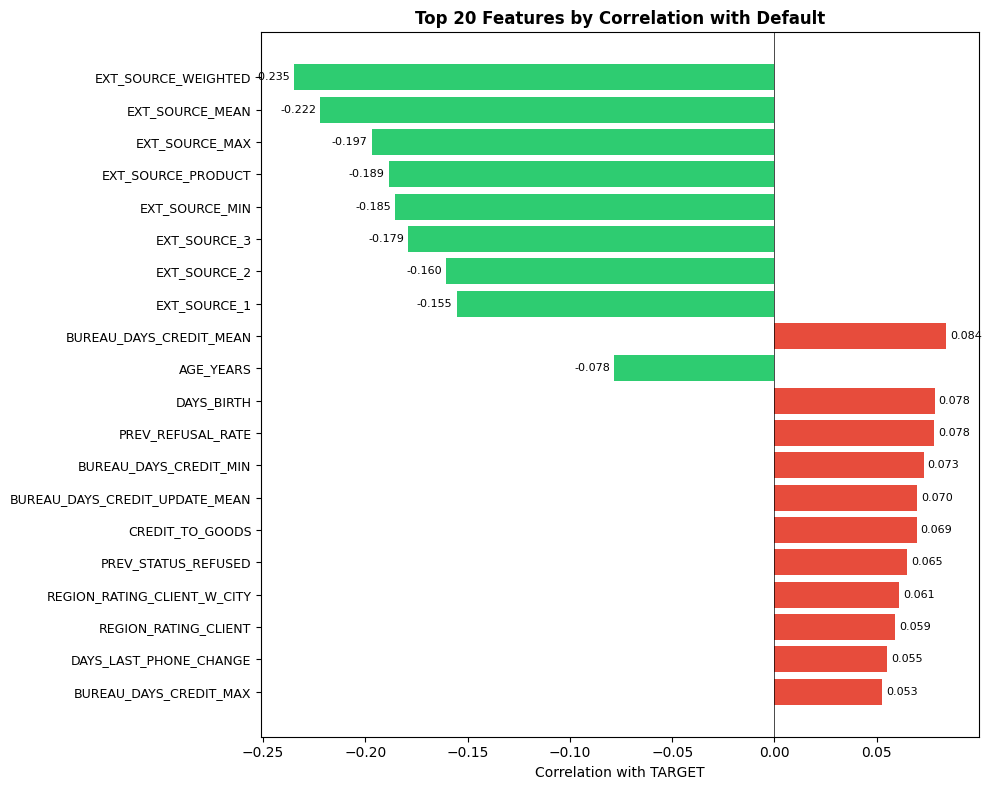


🎯 KEY INSIGHT: External source features remain the most predictive!


In [24]:
# =============================================================================
# 6.5 VISUALIZE TOP CORRELATIONS
# =============================================================================

# Get top 20 most correlated features (absolute value)
top_corr = correlations.abs().sort_values(ascending=False).head(20)
top_features = top_corr.index.tolist()

# Create correlation bar plot
fig, ax = plt.subplots(figsize=(10, 8))

colors = ['#e74c3c' if correlations[f] > 0 else '#2ecc71' for f in top_features]
bars = ax.barh(range(len(top_features)), [correlations[f] for f in top_features], color=colors)

ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features, fontsize=9)
ax.set_xlabel('Correlation with TARGET')
ax.set_title('Top 20 Features by Correlation with Default', fontsize=12, fontweight='bold')
ax.axvline(x=0, color='black', linewidth=0.5)
ax.invert_yaxis()

# Add value labels
for i, v in enumerate([correlations[f] for f in top_features]):
    ax.text(v + 0.002 if v > 0 else v - 0.002, i, f'{v:.3f}', 
            va='center', ha='left' if v > 0 else 'right', fontsize=8)

plt.tight_layout()
plt.savefig(PROJECT_ROOT / 'reports' / 'feature_correlations.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n🎯 KEY INSIGHT: External source features remain the most predictive!")

# 7. Summary and Next Steps

In [25]:
print("=" * 60)
print("FEATURE ENGINEERING COMPLETE!")
print("=" * 60)

print(f"""
📊 FINAL DATASET:
   - Rows: {df.shape[0]:,}
   - Features: {df.shape[1]}
   - Saved to: data/processed/features_train.csv

🔧 FEATURES CREATED:

1. APPLICATION FEATURES ({engineered_app} new):
   - Financial ratios (debt-to-income, payment burden)
   - Time-based (age, employment years)
   - External source combinations
   - Document counts

2. BUREAU FEATURES ({bureau_cols_count}):
   - Loan counts and amounts
   - Active/closed ratios
   - Overdue indicators
   - Credit type breakdown

3. PREVIOUS APPLICATION FEATURES ({prev_cols_count}):
   - Application history
   - Approval/refusal rates
   - Contract type breakdown

🔑 KEY FINDINGS:
   - EXT_SOURCE features remain most predictive
   - Payment burden and debt ratios show signal
   - Bureau history adds valuable information

📋 NEXT STEPS:
   1. Train XGBoost model (Notebook 03)
   2. Evaluate with AUC-ROC
   3. Generate SHAP explanations (Notebook 04)
""")

FEATURE ENGINEERING COMPLETE!

📊 FINAL DATASET:
   - Rows: 307,511
   - Features: 213
   - Saved to: data/processed/features_train.csv

🔧 FEATURES CREATED:

1. APPLICATION FEATURES (20 new):
   - Financial ratios (debt-to-income, payment burden)
   - Time-based (age, employment years)
   - External source combinations
   - Document counts

2. BUREAU FEATURES (41):
   - Loan counts and amounts
   - Active/closed ratios
   - Overdue indicators
   - Credit type breakdown

3. PREVIOUS APPLICATION FEATURES (30):
   - Application history
   - Approval/refusal rates
   - Contract type breakdown

🔑 KEY FINDINGS:
   - EXT_SOURCE features remain most predictive
   - Payment burden and debt ratios show signal
   - Bureau history adds valuable information

📋 NEXT STEPS:
   1. Train XGBoost model (Notebook 03)
   2. Evaluate with AUC-ROC
   3. Generate SHAP explanations (Notebook 04)



---
**End of Notebook 02: Feature Engineering**

Next: `03_model_training.ipynb`